# PID controller with a brake

Example taken from: Chaudhuri, S., & Solar-Lezama, A. (2010, June). Smooth interpretation. In Proceedings of the 31st ACM SIGPLAN Conference on Programming Language Design and Implementation (pp. 279-291).

```
b1, b2, b3, b4, s0, s1, s2 = ?

while(t < T):

    # decides whether brake is needed
    if b1*d+b2>0 and b3*d+4>0 {
        brakev = -1
    } else {
        brakev = 1
    }

    d = ang - 3.14
    torq = s0 *  d + s1 * v + s2 * id + brakev + gauss(0, 0.5);
    id = 0.9*id + d
    oldv= v 

    v = v + 0.01*torq + gauss(0, 0.5)
    ang = ang + 0.05*(v + oldv) + gauss(0, 0.1)

    if ang > 6.28 {
        ang = ang - 6.28
    } elif ang < 0 {
        ang = and + 6.28
    }  
```

### Original Model

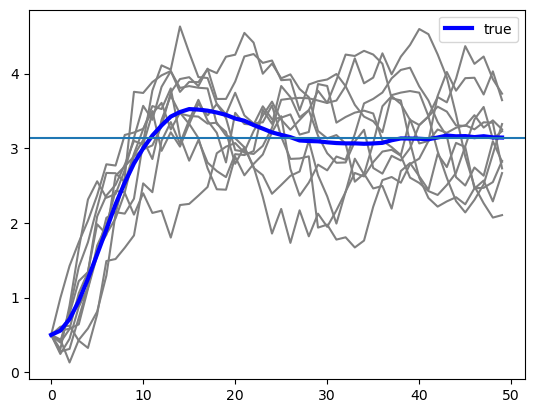

In [1]:
from cps.original_models import *

orig_params = {'T': 50,
               'init_ang': 0.5,
               's0': 46.,
               's1': -23.,
               's2': 0.}

target = 3.14
T = orig_params['T']
        

orig_traj = generate_traj(pid, 500, orig_params)

plot_traj_set(orig_traj, single_traj=10, label='true')
plt.axhline(y=target)


### SOGA program

In [13]:
from optimization import *
torch.set_default_dtype(torch.float64)

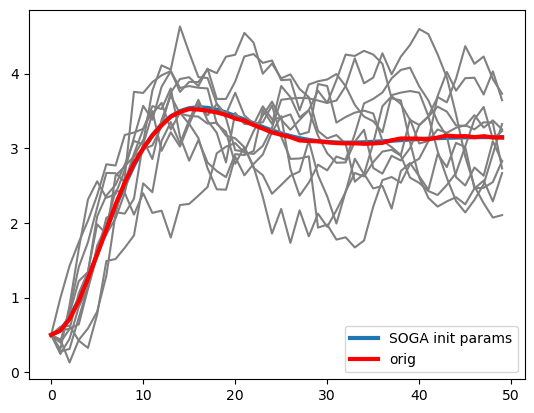

In [47]:
# this is to check that for the correct value of the parameter, the loss is negative and the mean produced by SOGA is almost exactly the true mean

# creates the cfg for the SOGA model
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s0':46., 's1':-23., 's2':0.}
params_dict = initialize_params(params)

# computes SOGA output
output_dist = start_SOGA(cfg, params_dict)

# plot
y_init = output_dist.gm.mean()[:T].detach()
plt.plot(range(T), y_init, lw=3, label='SOGA init params')
plot_traj_set(orig_traj, single_traj=10, color='red', label='orig')

s0: 46.09999999977329 s1: -23.099999999667933 s2: -0.09999999681330281  loss: 3093.3936981433335
s0: 47.100267799027776 s1: -24.097176220398072 s2: -1.0968724312168951  loss: 3085.755847552079
s0: 48.10164843450533 s1: -25.082269981558277 s2: -2.080205753067489  loss: 3078.3180098252615
s0: 49.10472690326879 s1: -26.048115578498603 s2: -3.041618217197717  loss: 3071.0757943046046
s0: 50.10970502700329 s1: -26.99125930834463 s2: -3.9766998618927345  loss: 3064.015329645983
s0: 51.11651618503242 s1: -27.911083979879667 s2: -4.884187522194631  loss: 3057.117941829131
s0: 52.12495822208595 s1: -28.80859556802652 s2: -5.764692908128558  loss: 3050.3641693637746
s0: 53.134786775753106 s1: -29.685496629631686 s2: -6.619691472826777  loss: 3043.736019782835
s0: 54.145764091399265 s1: -30.54365780103535 s2: -7.450926226170057  loss: 3037.2177985071485
s0: 55.15767839992132 s1: -31.384874277029393 s2: -8.260121095877835  loss: 3030.7961608760997
Optimization performed in  397.992
s0: 56.06905187

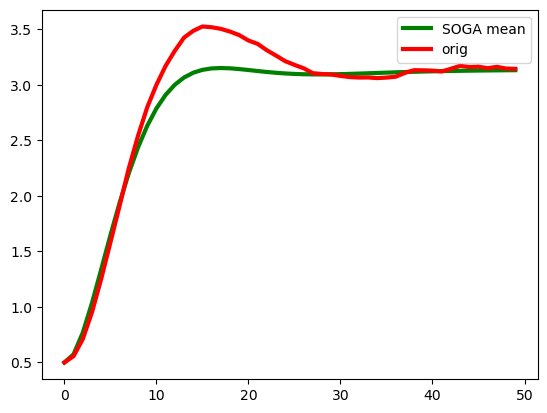

In [48]:
# Trying with neg_log_likelihood as loos

# Optimization in SOGA

# We start from the same initial parameters and try to improve them

# Define loss
observed_traj = target*torch.ones(100, T)
loss = lambda dist : neg_log_likelihood(observed_traj, dist, idx=list(range(1,T)))

# cfg for SOGA
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

# initialize parameters
params = {'s0':46., 's1':-23., 's2':0.}
params_dict = initialize_params(params)

# gradient based optimization
optimize(cfg, params_dict, loss, n_steps=100, lr=0.1)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

# plots the final result
compiledFile=compile2SOGA('../programs/SOGA/Optimization/CaseStudies/PID.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plt.plot(range(T), output_dist.gm.mean()[:T].detach(), lw=3, color='green', label='SOGA mean')
plot_traj_set(orig_traj, single_traj=0, color='red', label='orig')

## Pyro

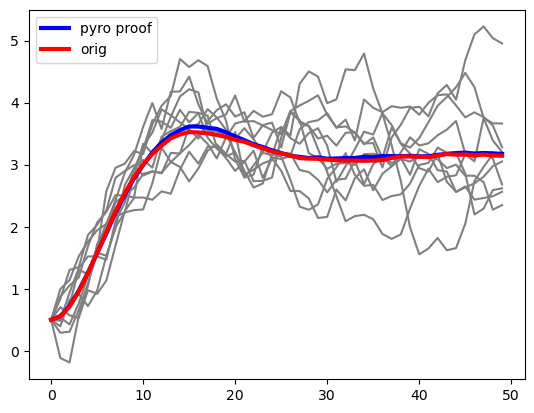

In [26]:
from cps.pyro_models import *

# This is to check that the model works as expected for the right values of the parameters

T = 50
init_ang = 0.5

def pid_pyro_proof(batch_size):

    # Sample parameters
    s0 = pyro.sample("s0", dist.Normal(46., 0.1))
    s1 = pyro.sample("s1", dist.Normal(-23, 0.1))
    s2 = pyro.sample("s2", dist.Normal(0., 0.1))

    target = 3.14
    dt = 0.1
    inertia = 10
    decay = 0.9

    traj_list = []
    v = torch.zeros(batch_size)
    ang = torch.ones(batch_size) * init_ang
    id = torch.zeros(batch_size)

    noise = dist.Normal(0., 0.25)
    noise_ang = dist.Normal(0., 0.25)

    for i in range(T):
        traj_list.append(ang)
        d = target - ang
        torq = s0 * d + s1 * v + s2 * id
        id = decay * id + d * dt
        oldv = v
        v = v + (dt / inertia) * torq + noise.rsample([batch_size])
        ang = ang + (dt / 2) * (v + oldv) + noise_ang.rsample([batch_size])

    traj = torch.stack(traj_list, dim=1)

    return traj

pyro_traj = pid_pyro_proof(batch_size=500)

plot_traj_set(pyro_traj, single_traj=10, label='pyro proof')
plot_traj_set(orig_traj, single_traj=0, color='red', label='orig')

### MCMC

In [50]:
observed_traj = target*torch.ones(100, T) 

init_params = {'T': 50,
               'init_ang': 0.5,
               's0': 46.,
               's1': -23.,
               's2': 0.}


pid_pyro = create_pid_pyro(init_params, eps=2.0)

posterior_samples = run_NUTS(pid_pyro, observed_traj, num_samples=500, warmup_steps=100, adapt_step_size=False, step_size=1e-2)


Sample:  18%|█▊        | 105/600 [00:17,  7.20it/s, step size=1.00e-02, acc. prob=0.000]

KeyboardInterrupt: 

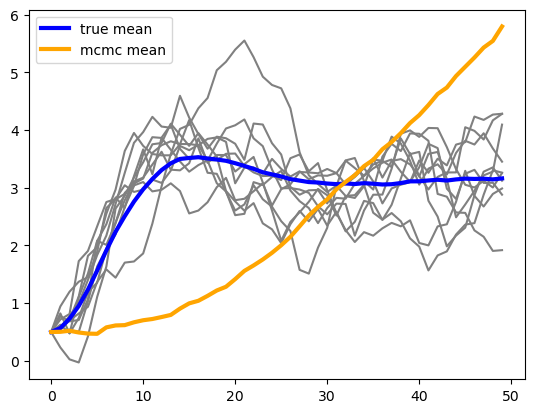

In [13]:
### generate trajectories for posterior estimations and plots the mean trajectory
mcmc_params = {'T': 50,
               'init_ang': 0.5,
               's0': posterior_samples['s0'].mean().item(),
               's1': posterior_samples['s1'].mean().item(),
               's2': posterior_samples['s2'].mean().item()}


mcmc_traj = generate_traj(pid, 100, mcmc_params)

plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')
plot_traj_set(mcmc_traj, single_traj=0, color='orange', label='mcmc mean')

### VI Inference

In [51]:
observed_traj = target*torch.ones(100, T) + 0.5*torch.randn(100, T)

init_params = {'T': 50,
               'init_ang': 0.5,
               's0': torch.tensor(46.),
               's1': torch.tensor(-23.),
               's2': torch.tensor(0.)}

Step 0: Loss = 30786.89784994354
Step 100: Loss = 30396.527919027354
Step 200: Loss = 30438.477480771166
Step 300: Loss = 30319.889500031688
Step 400: Loss = 30302.379948333295
Step 500: Loss = 30202.2448825694
Step 600: Loss = 30180.430509385264
Step 700: Loss = 30197.735748937972
Step 800: Loss = 30067.188444022057
Step 900: Loss = 30063.215772452175
Optimization performed in 841.37 seconds


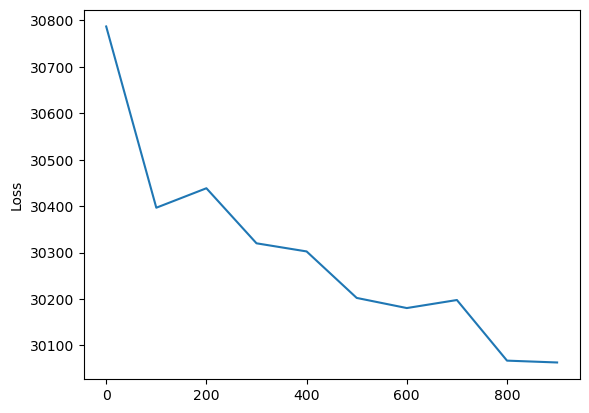

In [52]:
pid_pyro = create_pid_pyro(init_params, eps=1.0)

pid_guide = create_pid_guide(init_params)

run_SVI(pid_pyro, pid_guide, orig_traj, num_steps=1000, lr=0.05, num_particles=10, loss_plot=True)

Optimized s0: 75.28936807373637, s1: -42.92058593164876, s2: 21.934411107435235


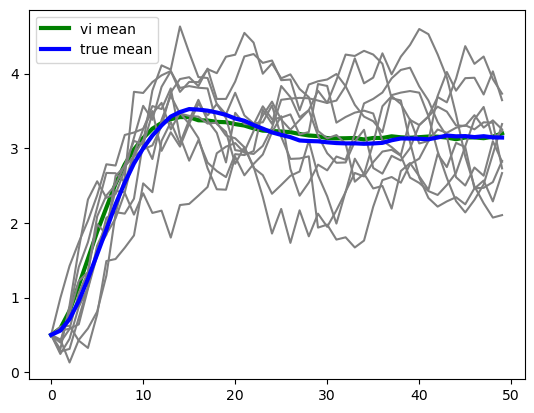

In [53]:
# Retrieve optimized parameters
vi_s0 = pyro.param("s0_loc").item()
vi_s1 = pyro.param("s1_loc").item()
vi_s2 = pyro.param("s2_loc").item()

print(f"Optimized s0: {vi_s0}, s1: {vi_s1}, s2: {vi_s2}")

# plot

vi_traj = generate_traj(pid, 500, {'T': 50,
                                   'init_ang': 0.5,
                                   's0': vi_s0,
                                   's1': vi_s1,
                                   's2': vi_s2})

plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=10, color='blue', label='true mean')


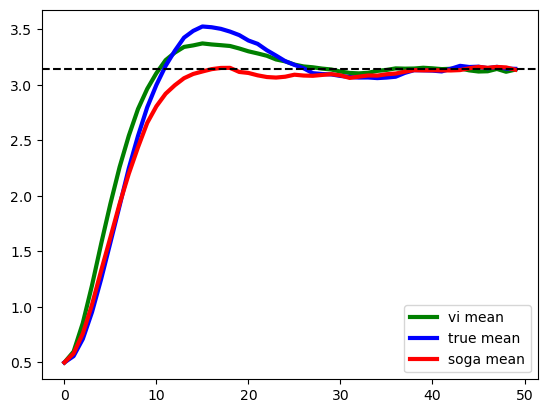

In [55]:
vi_traj = generate_traj(pid, 500, {'T': 50,
                                   'init_ang': 0.5,
                                   's0': vi_s0,
                                   's1': vi_s1,
                                   's2': vi_s2})

soga_traj = generate_traj(pid, 500, {'T': 50,
                                     'init_ang': 0.5,
                                     's0': params_dict['s0'].item(),
                                     's1': params_dict['s1'].item(),
                                     's2': params_dict['s2'].item()})

plot_traj_set(vi_traj, single_traj=0, color='green', label='vi mean')
plot_traj_set(orig_traj, single_traj=0, color='blue', label='true mean')
plot_traj_set(soga_traj, single_traj=0, color='red', label='soga mean')
plt.axhline(y=target, color='black', linestyle='--', label='target')